In [99]:
import pandas as pd
import ydata_profiling
import datetime

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
results = pd.read_csv(r"data/results.csv")
races = pd.read_csv(r"data/races.csv")
drivers = pd.read_csv(r"data/drivers.csv")
driver_standings = pd.read_csv(r"data/driver_standings.csv")
constructors = pd.read_csv(r"data/constructors.csv")
constructor_standings = pd.read_csv(r"data/constructor_standings.csv")
constructor_results = pd.read_csv(r"data/constructor_results.csv")
pit_stops = pd.read_csv(r"data/pit_stops.csv")
status = pd.read_csv(r"data/status.csv")
seasons = pd.read_csv(r"data/seasons.csv")

circuits = pd.read_csv(r"data/circuits.csv")
lap_times = pd.read_csv(r"data/lap_times.csv")
qualifying = pd.read_csv(r"data/qualifying.csv")
sprint_results = pd.read_csv(r"data/sprint_results.csv")

In [4]:
print('\nDrivers:')
print((drivers == "\\N").sum())
print('\nRaces:')
print((races == "\\N").sum())
print('\nResults:')
print((results == "\\N").sum())
print('\nConstructor_results:')
print((constructor_results == "\\N").sum())
print('\nQualifying:')
print((qualifying == "\\N").sum())
print('\nSprint_results:')
print((sprint_results == "\\N").sum())

# W pozostałych zbiorach nie ma pustych wartości:
# print((circuits == "\\N").sum())
# print((constructor_standings == "\\N").sum())
# print((constructors == "\\N").sum())
# print((driver_standings == "\\N").sum())
# print((lap_times == "\\N").sum())
# print((pit_stops == "\\N").sum())
# print((seasons == "\\N").sum())
# print((status == "\\N").sum())


Drivers:
driverId         0
driverRef        0
number         802
code           757
forename         0
surname          0
dob              0
nationality      0
url              0
dtype: int64

Races:
raceId            0
year              0
round             0
circuitId         0
name              0
date              0
time            731
url               0
fp1_date       1035
fp1_time       1057
fp2_date       1035
fp2_time       1057
fp3_date       1053
fp3_time       1072
quali_date     1035
quali_time     1057
sprint_date    1107
sprint_time    1110
dtype: int64

Results:
resultId               0
raceId                 0
driverId               0
constructorId          0
number                 6
grid                   0
position           10916
positionText           0
positionOrder          0
points                 0
laps                   0
time               18931
milliseconds       18931
fastestLap         18478
rank               18249
fastestLapTime     18478
fastestLapSpeed

In [5]:
# Stworzenie zmiennej z punktami/rankingiem teamu przed danym wyścigiem

constructor_standings = constructor_standings.sort_values(by='raceId')
constructor_standings['points_before'] = constructor_standings.groupby('constructorId')['points'].shift(1)
constructor_standings['ranking_before'] = constructor_standings.groupby('constructorId')['position'].shift(1)
constructor_standings.dropna(inplace=True)
constructor_standings['points_before']=constructor_standings['points_before'].astype(int)
constructor_standings['ranking_before']=constructor_standings['ranking_before'].astype(int)
constructor_standings = constructor_standings[['raceId','constructorId','points_before','ranking_before']]

In [6]:
constructor_standings

,raceId,constructorId,points_before,ranking_before
3676,2,9,0,8
3684,2,23,18,1
3682,2,7,11,2
3675,2,6,0,9
3680,2,3,3,4
...,...,...,...,...
13205,1126,117,40,5
13206,1126,15,0,10
13207,1126,210,5,7
13208,1126,215,7,6


In [7]:
# Stworzenie zmiennej z punktami/rankingiem kierowcy przed danym wyścigiem

driver_standings = driver_standings.sort_values(by='raceId')
driver_standings['points_before'] = driver_standings.groupby('driverId')['points'].shift(1)
driver_standings['ranking_before'] = driver_standings.groupby('driverId')['position'].shift(1)
driver_standings.dropna(inplace=True)
driver_standings['points_before']=driver_standings['points_before'].astype(int)
driver_standings['ranking_before']=driver_standings['ranking_before'].astype(int)

In [8]:
# Stworzenie zmiennej ze średnim czasem trwania pit-stopu w sezonie dla poszczególnych teamów

pit_stops_merged = pd.merge(pit_stops, results, on = ['driverId','raceId'], how = 'left')
pit_stops_merged = pd.merge(pit_stops_merged, races, on = ['raceId'], how = 'left')
pit_stops_merged = pit_stops_merged[['raceId','constructorId','duration','year']]
pit_stops_merged['duration'] = pd.to_numeric(pit_stops_merged['duration'], errors='coerce')
pit_stops_merged['avg_season_duration'] = pit_stops_merged.groupby(['constructorId', 'year'])['duration'].transform('mean')
pit_stops_merged = pit_stops_merged[['year','constructorId','avg_season_duration']]
pit_stops_merged = pit_stops_merged.drop_duplicates()

In [9]:
pit_stops_merged.loc[pit_stops_merged['year']==2024].sort_values(by='constructorId')

,year,constructorId,avg_season_duration
10578,2024,1,22.434800
10550,2024,3,23.691211
10552,2024,6,21.888706
10554,2024,9,22.328842
10547,2024,15,26.523905
10548,2024,117,22.919609
10551,2024,131,22.246316
10546,2024,210,23.899478
10549,2024,214,24.166955
10560,2024,215,22.021375


In [10]:
# Łączenie zbiorów i usuwanie niepotrzebnych/zduplikowanych kolumn

merged_df = pd.merge(results, status, on = 'statusId', how = 'left')
merged_df = pd.merge(merged_df, drivers, on = 'driverId', how = 'left')
merged_df = pd.merge(merged_df, races, on = 'raceId', how = 'left')
merged_df = pd.merge(merged_df, constructors, on = 'constructorId', how = 'left')
merged_df = pd.merge(merged_df, driver_standings, on = ['driverId','raceId'], how = 'left')
merged_df = pd.merge(merged_df, pit_stops_merged, on = ['year','constructorId'], how = 'left')
merged_df = pd.merge(merged_df, constructor_standings, on = ['raceId','constructorId'], how = 'left')
merged_df = merged_df.drop(['driverRef','number_y','number_x','code','dob','nationality_x','url_x','round'
                            ,'time_y','url_y','constructorRef','nationality_y','url','fp1_date'
                           ,'fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date'
                           ,'quali_time','sprint_date','sprint_time','position_x','fastestLap'
                           ,'fastestLapTime','rank','fastestLapSpeed','driverStandingsId'
                             ,'points_y','position_y','positionText_y','wins'], axis = 1)

In [11]:
# Uporządkowanie kolumn i zmiana nazw
order = ['resultId','raceId','name_x','year','date','driverId','forename','surname','constructorId','name_y','avg_season_duration','grid'
        ,'positionText_x','positionOrder','points_x','points_before_x','ranking_before_x','points_before_y','ranking_before_y','laps','time_x','milliseconds'
        ,'statusId','status','circuitId']
merged_df = merged_df[order]
merged_df = merged_df.rename(columns={'name_x':'race_name','date':'race_date','name_y':'constructor_name','grid':'start_position'
                                     ,'time_x':'time','rank':'fastest_lap_rank','positionOrder':'end_position','points_before_x':'driver_ranking_points_before_race'
                                     ,'ranking_before_x':'driver_ranking_before_race','positionText_x':'end_positionText','points_x':'points','avg_season_duration':'avg_season_pit_stop_duration'
                                     ,'ranking_before_y':'constructor_ranking_before_race','points_before_y':'constructor_ranking_points_before_race'})

In [12]:
(merged_df == "\\N").sum()

resultId                                      0
raceId                                        0
race_name                                     0
year                                          0
race_date                                     0
driverId                                      0
forename                                      0
surname                                       0
constructorId                                 0
constructor_name                              0
avg_season_pit_stop_duration                  0
start_position                                0
end_positionText                              0
end_position                                  0
points                                        0
driver_ranking_points_before_race             0
driver_ranking_before_race                    0
constructor_ranking_points_before_race        0
constructor_ranking_before_race               0
laps                                          0
time                                    

In [13]:
merged_df['status'].value_counts()
# Można pomyśleć czy bierzemy tylko Finished

status
Finished          7463
+1 Lap            3944
Engine            2022
+2 Laps           1600
Accident          1057
                  ... 
Launch control       1
Tyre puncture        1
+26 Laps             1
CV joint             1
Crankshaft           1
Name: count, Length: 137, dtype: int64

In [243]:
merged_df = merged_df.loc[merged_df['status']=='Finished']
merged_df = merged_df.loc[merged_df['year']>=2014]
merged_df = merged_df.loc[merged_df['start_position']!=0] #
merged_df.dropna(inplace=True)
merged_df['driver_ranking_points_before_race'] = merged_df['driver_ranking_points_before_race'].astype(int)
merged_df['driver_ranking_before_race'] = merged_df['driver_ranking_before_race'].astype(int)
merged_df['constructor_ranking_points_before_race'] = merged_df['constructor_ranking_points_before_race'].astype(int)
merged_df['constructor_ranking_before_race'] = merged_df['constructor_ranking_before_race'].astype(int)
(merged_df == "\\N").sum()

resultId                                  0
raceId                                    0
race_name                                 0
year                                      0
race_date                                 0
driverId                                  0
forename                                  0
surname                                   0
constructorId                             0
constructor_name                          0
avg_season_pit_stop_duration              0
start_position                            0
end_positionText                          0
end_position                              0
points                                    0
driver_ranking_points_before_race         0
driver_ranking_before_race                0
constructor_ranking_points_before_race    0
constructor_ranking_before_race           0
laps                                      0
time                                      0
milliseconds                              0
statusId                        

In [285]:
# for col in merged_df.columns:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2157 entries, 22127 to 26397
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   resultId                                2157 non-null   int64  
 1   raceId                                  2157 non-null   int64  
 2   race_name                               2157 non-null   object 
 3   year                                    2157 non-null   int64  
 4   race_date                               2157 non-null   object 
 5   driverId                                2157 non-null   int64  
 6   forename                                2157 non-null   object 
 7   surname                                 2157 non-null   object 
 8   constructorId                           2157 non-null   int64  
 9   constructor_name                        2157 non-null   object 
 10  avg_season_pit_stop_duration            2157 non-null   floa

### Some transform for modelling

In [299]:
model_df = merged_df.drop(["forename","status","end_positionText", "status", "statusId", "laps"], axis = 1).copy()
# constructor_ranking_points_before_race, driver_ranking_points_before_race - to transform

# model_df["constructor_ranking_points_before_race_mean"] =  model_df.groupby("raceId")["constructor_ranking_points_before_race"].mean()
model_df["constructor_ranking_points_before_race_mean"] = model_df.groupby("raceId")["constructor_ranking_points_before_race"].transform('mean')
model_df["constructor_ranking_points_before_race_relative"] = model_df["constructor_ranking_points_before_race"] - model_df["constructor_ranking_points_before_race_mean"]
model_df["constructor_ranking_points_before_race_relative"].describe()



count    2.157000e+03
mean    -7.642370e-16
std      1.348958e+02
min     -4.010000e+02
25%     -8.015385e+01
50%     -1.635294e+01
75%      5.811111e+01
max      5.692941e+02
Name: constructor_ranking_points_before_race_relative, dtype: float64

In [300]:
model_df["driver_ranking_points_before_race_mean"] = model_df.groupby("raceId")["driver_ranking_points_before_race"].transform('mean')
model_df["driver_ranking_points_before_race_relative"] = model_df["driver_ranking_points_before_race"] - model_df["driver_ranking_points_before_race_mean"]
model_df["driver_ranking_points_before_race_relative"].describe()

count    2.157000e+03
mean    -6.061190e-16
std      7.194303e+01
min     -1.808333e+02
25%     -4.273333e+01
50%     -9.285714e+00
75%      2.725000e+01
max      4.230588e+02
Name: driver_ranking_points_before_race_relative, dtype: float64

In [301]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the data within each group
model_df["constructor_rp_rel_std"] = scaler.fit_transform(model_df["constructor_ranking_points_before_race_relative"].values.reshape(-1, 1))
model_df["driver_rp_rel_std"] = scaler.fit_transform(model_df["driver_ranking_points_before_race_relative"].values.reshape(-1, 1))

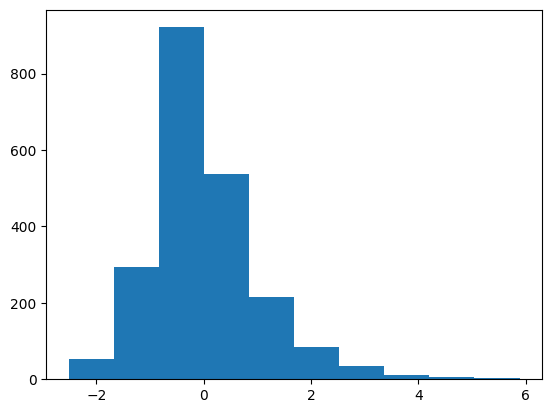

In [302]:
from matplotlib import pyplot as plt

plt.hist(model_df["driver_rp_rel_std"])
plt.show()

In [303]:
cols = ['race_name', 'surname', 'constructor_name', "start_position", "constructor_ranking_before_race", "driver_ranking_before_race"]

for col in cols:
    model_df[col] = model_df[col].astype(str)
    if col == "start_position":
        model_df[col] = model_df[col].apply(lambda x: "start_position" + "_" + x)
    elif col == "constructor_ranking_before_race":
        model_df[col] = model_df[col].apply(lambda x: "constructor_rank" + "_" + x)
    elif col == "driver_ranking_before_race":
        model_df[col] = model_df[col].apply(lambda x: "driver_rank" + "_" +  x)
    model_df[col] = model_df[col].str.strip().str.lower()
    model_df[col] = model_df[col].apply(lambda name: name.replace(' ', '_'))
    # Use get_dummies to convert categorical variable into dummy/indicator variables
    dummy_model_df = pd.get_dummies(model_df[col]).astype(int)

    # Concatenate the dummy variables with the original DataFrame
    model_df = pd.concat([model_df, dummy_model_df], axis=1)

In [304]:
model_df["race_date"] = pd.to_datetime(model_df["race_date"]) 
model_df["day"] = model_df["race_date"].dt.day_of_year
model_df["day"]

22127     75
22129     75
22130     75
22131     75
22132     75
        ... 
26393    126
26394    126
26395    126
26396    126
26397    126
Name: day, Length: 2157, dtype: int32

In [305]:


model_df.drop(["constructor_ranking_points_before_race_mean", 
               "constructor_ranking_points_before_race_relative", 
               "driver_ranking_points_before_race_mean",
               "driver_ranking_points_before_race_relative",
               "constructor_ranking_points_before_race",
               "driver_ranking_points_before_race",
               "constructor_ranking_before_race", 
               "driver_ranking_before_race",
               "constructorId",
               "points",
               "driverId",
               "circuitId",
               "race_date",
               "surname",
               "race_name",
               'constructor_name',
               'start_position',
               "raceId",
               "resultId",
               "milliseconds"], axis = 1, inplace = True)



merged_df

In [306]:
model_df.iloc[:,1:20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2157 entries, 22127 to 26397
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avg_season_pit_stop_duration  2157 non-null   float64
 1   end_position                  2157 non-null   int64  
 2   time                          2157 non-null   object 
 3   constructor_rp_rel_std        2157 non-null   float64
 4   driver_rp_rel_std             2157 non-null   float64
 5   70th_anniversary_grand_prix   2157 non-null   int32  
 6   abu_dhabi_grand_prix          2157 non-null   int32  
 7   australian_grand_prix         2157 non-null   int32  
 8   austrian_grand_prix           2157 non-null   int32  
 9   azerbaijan_grand_prix         2157 non-null   int32  
 10  bahrain_grand_prix            2157 non-null   int32  
 11  belgian_grand_prix            2157 non-null   int32  
 12  brazilian_grand_prix          2157 non-null   int32  
 13  bri

In [307]:
model_df["time2"] = model_df["time"].astype(str)
model_df["time2"]= model_df.apply(lambda x: "0" if (":" in x["time"]) & (x["end_position"] == 1) else x["time"], axis = 1)
model_df["time2"]= model_df["time2"].apply(lambda name: name.replace('+', ''))
model_df[["minutes","seconds"]]= model_df["time2"].str.split(':', expand=True)
model_df["seconds"] = model_df.apply(lambda x: x["minutes"] if "." in x["minutes"] else x["seconds"], axis = 1)
model_df["seconds"] = model_df.apply(lambda x: "0" if x["seconds"] is None else x["seconds"], axis = 1)
model_df["minutes"] = model_df.apply(lambda x: "0" if x["minutes"] == x["seconds"] else x["minutes"], axis = 1)
model_df["minutes"] = model_df.apply(lambda x: "0" if x["minutes"] == x["seconds"] else x["minutes"], axis = 1)
model_df["time2"]= model_df["seconds"].astype(float)
model_df["time"] = model_df["time2"] + model_df["minutes"].astype(float)*60

In [308]:
model_df["avg_season_pit_stop_duration"] = scaler.fit_transform(model_df["avg_season_pit_stop_duration"].values.reshape(-1, 1))

In [309]:

model_df.drop(["time2",
               "seconds",
               "minutes"], axis = 1, inplace = True)

In [310]:
model_df.to_excel("model_df.xlsx")